In [79]:
import polars as pl # pandas alternative (way faster, reading data on pandas took ~7s, but on polars only ~0.4s)
import plotnine as pltn
import os
import matplotlib.pyplot as plt
from IPython.display import Markdown, display, display_markdown
import nltk # language operations
import langid
import wordcloud
import numpy as np
from scipy.stats import chisquare, t, spearmanr, kruskal

from typing import Tuple, Any

import warnings
warnings.filterwarnings('ignore')

COLOR_PALETTE =  pltn.scale_fill_manual({"Negative":"firebrick", "Neutral":"goldenrod", "Positive":"limegreen"})

# Dataset overview
Let's look at the dataset before we develop the model.

## Dataset Source
[Source](https://huggingface.co/datasets/AmaanP314/youtube-comment-sentiment)
## Dataset Contents
Each record in the dataset includes the following fields:
- **CommentID:** A unique identifier assigned to each YouTube comment. This allows for individual tracking and analysis of comments.
- **VideoID:** The unique identifier of the YouTube video to which the comment belongs. This links each comment to its corresponding video.
- **VideoTitle:** The title of the YouTube video where the comment was posted. This provides context about the video's content.
- **AuthorName:** The display name of the user who posted the comment. This indicates the commenter's identity.
- **AuthorChannelID:** The unique identifier of the YouTube channel of the comment's author. This allows for tracking comments across different videos from the same author.
- **CommentText:** The actual text content of the YouTube comment. This is the raw data used for sentiment analysis.
- **Sentiment:** The sentiment classification of the comment, typically categorized as positive, negative, or neutral. This represents the emotional tone of the comment.
- **Likes:** The number of likes received by the comment. This indicates the comment's popularity or agreement from other users.
- **Replies:** The number of replies to the comment. This indicates the level of engagement and discussion generated by the comment.
- **PublishedAt:** The date and time when the comment was published. This allows for time-based analysis of comment trends.
- **CountryCode:** The two-letter country code of the user that posted the comment. This can be used to analyze regional sentiment.
- **CategoryID:** The category ID of the video that the comment was posted on. This allows for analysis of sentiment across video categories.

## What do we want to know about the dataset:
- [x] Nan's/Null value counts
- [x] Distribution of length of the comments is crucial for model design.
- [x] Distribution of Sentiments (target variables)
- [x] Number of unique videos, comments and authors
- [x] Countries from where the video was published
- [ ] Explanation of for category ID
- [ ] Likes and Replies distribution

In [2]:
data = pl.read_csv("../dataset/youtube-comments-sentiment.csv")

In [3]:
data.glimpse()

Rows: 1032225
Columns: 12
$ CommentID       <str> 'UgyRjrEdJIPrf68uND14AaABAg', 'UgxXxEIySAwnMNw8D7N4AaABAg', 'UgxB0jh2Ur41mcXr5IB4AaABAg', 'UgwMOh95MfK0GuXLLrF4AaABAg', 'UgxJuUe5ysG8OSbABAl4AaABAg', 'UgzoTpY5F11FtcooFRR4AaABAg', 'UgzJ-2rV0-YNPyMj0u14AaABAg', 'UgwuFh4s9cHu3dHrPqJ4AaABAg', 'UgwzYX76p4RK8AHVcYN4AaABAg', 'UgzW7h-gmtmgIFFClLJ4AaABAg'
$ VideoID         <str> 'mcY4M9gjtsI', '2vuXcw9SZbA', 'papg2tsoFzg', '31KTdfRH6nY', '-hV6aeyPHPA', 'NnJ4XJdZW4I', 'X4wNLFrv9Co', 'sKniMxl9zwo', 'yUImrnDqGUk', '5VPxcrvVkBc'
$ VideoTitle      <str> 'They killed my friend.#tales #movie #shorts', 'Man Utd conceding first penalty at home in years and this is their reaction 😭', 'Welcome to Javascript Course', 'Building web applications in Java with Spring Boot 3 – Tutorial', 'After a new engine her car dies on her way home makes me think the worst! 😱#fyp #mobile #love #help', 'The lawyer brilliantly got it out of the way #bettercallsaul #suits #shorts', 'Which one will you choose to use the cola ke

In [4]:
data.head()

CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
str,str,str,str,str,str,str,i64,i64,str,str,i64
"""UgyRjrEdJIPrf68uND14AaABAg""","""mcY4M9gjtsI""","""They killed my friend.#tales #…","""@OneWhoWandered""","""UC_-UEXaBL1dqqUPGkDll49A""","""Anyone know what movie this is…","""Neutral""",0,2,"""2025-01-15 00:54:55""","""NZ""",1
"""UgxXxEIySAwnMNw8D7N4AaABAg""","""2vuXcw9SZbA""","""Man Utd conceding first penalt…","""@chiefvon3068""","""UCZ1LcZESjYqzaQRhjdZJFwg""","""The fact they're holding each …","""Positive""",0,0,"""2025-01-13 23:51:46""","""AU""",17
"""UgxB0jh2Ur41mcXr5IB4AaABAg""","""papg2tsoFzg""","""Welcome to Javascript Course""","""@Abdulla-ip8qr""","""UCWBK35w5Swy1iF5xIbEyw3A""","""waiting next video will be?""","""Neutral""",1,0,"""2020-07-06 13:18:16""","""IN""",27
"""UgwMOh95MfK0GuXLLrF4AaABAg""","""31KTdfRH6nY""","""Building web applications in J…","""@finnianthehuman""","""UCwQ2Z03nOcMxWozBb_Cv66w""","""Thanks for the great video. I…","""Neutral""",0,1,"""2024-09-18 12:04:12""","""US""",27
"""UgxJuUe5ysG8OSbABAl4AaABAg""","""-hV6aeyPHPA""","""After a new engine her car die…","""@ryoutubeplaylistb6137""","""UCTTcJ0tsAKQokmHB2qVb1qQ""","""Good person helping good peopl…","""Positive""",3,1,"""2025-01-10 19:39:03""","""US""",2


# Analysis
## Sentiment distribuion
Let's look at the distribution of out target variable

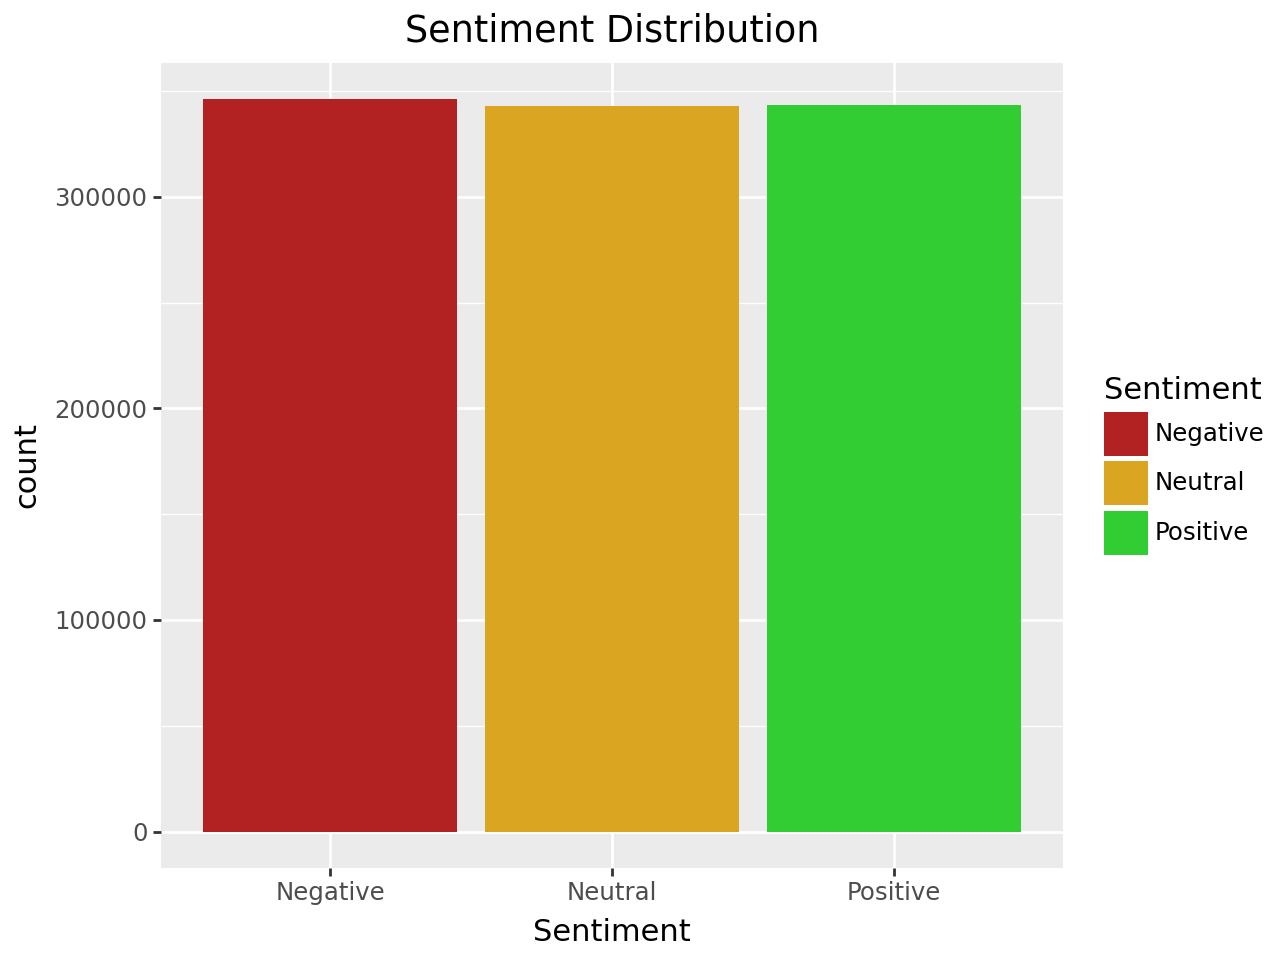

In [5]:
(pltn.ggplot(data) +
    pltn.aes("Sentiment",
             fill="Sentiment") +
    pltn.geom_bar() +
    pltn.labs(title="Sentiment Distribution") +
    COLOR_PALETTE
)

Looks like our data is uniformly distributed

## Number of unique videos

In [6]:
video_count = data["VideoID"].n_unique()
author_count = data["AuthorChannelID"].n_unique()
display(Markdown(
    f"Number of unique videos: **{video_count}** found in the dataset <br>" +
    f"    So this makes about **{len(data) / video_count:.2f}** comments per video on average <br>" +
    f"Number of unuque authors: **{author_count}**"
    ))

Number of unique videos: **4563** found in the dataset <br>    So this makes about **226.22** comments per video on average <br>Number of unuque authors: **759619**

Even though the dataset consist of over 1M comments there are only 4563 unique videos in dataset!

In [7]:
author_occurences = (data
                     .group_by("AuthorChannelID")
                     .agg(pl.len().alias("Author Occurences"))
                     )

num_occurences = (author_occurences
                  .group_by("Author Occurences")
                  .agg(pl.len().alias("Count"))
                  .sort(pl.col("Author Occurences"), descending=False)
                  )

num_occurences

Author Occurences,Count
u32,u32
1,680256
2,58631
3,12647
4,4105
5,1724
…,…
85,1
103,1
111,1


In [46]:
prc = num_occurences["Count"][0] / num_occurences["Count"].sum() * 100
display(Markdown(f"proportion of comments made by unique author: {prc:.2f}%"))

proportion of comments made by unique author: 89.55%

WOW! One commenter appeared in over *151044* comments? Lets look into that more closely.


In [8]:
author_occurences.sort(by="Author Occurences").select(pl.all().last())

AuthorChannelID,Author Occurences
str,u32
"""AugmentedCID""",151044


In [9]:
data.filter(pl.col("AuthorChannelID") == "AugmentedCID").select("AuthorName")

AuthorName
str
"""AugmentedUser"""
"""AugmentedUser"""
"""AugmentedUser"""
"""AugmentedUser"""
"""AugmentedUser"""
…
"""AugmentedUser"""
"""AugmentedUser"""
"""AugmentedUser"""


Oh, it seems that our *mystery commenter* is just a placeholder value for deleted channels
Let's now look at how much comments came from one video

/home/kuba/Dokumenty/projekty/python/Comment_analysis/youtube_venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 236'. Pick better value with 'binwidth'.


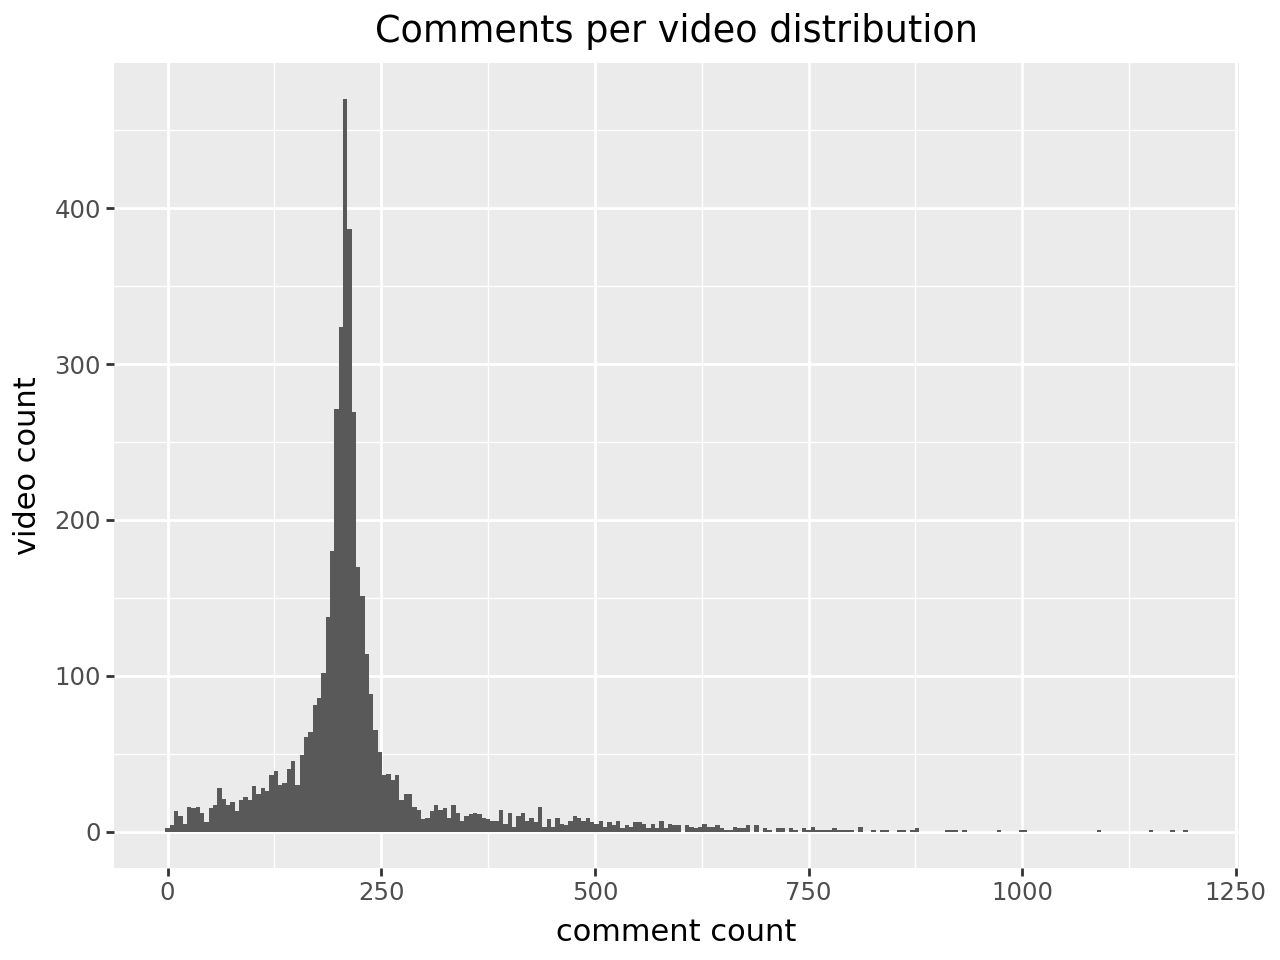

In [10]:
comments_per_video = (data
                      .group_by("VideoID")
                      .len())
(
pltn.ggplot(comments_per_video) +
    pltn.aes("len") +
    pltn.geom_histogram() +
    #pltn.geom_vline(pltn.aes(xintercept=comments_per_video["len"].median())) 
    pltn.labs(title="Comments per video distribution",
              x="comment count", 
              y="video count")
)

In [11]:
def get_quantiles(df: pl.DataFrame,
                  column_name: str
                  ) -> pl.DataFrame:
    return (df
            .select([pl.quantile(column_name, q).alias(str(q)) for q in (0, 0.25, 0.5, 0.75, 1)])
            .unpivot(variable_name="quantile")
            .select(pl.col("quantile", "value").cast(pl.Float64))
            )

get_quantiles(comments_per_video, "len")


quantile,value
f64,f64
0.0,1.0
0.25,187.0
0.5,209.0
0.75,229.0
1.0,1192.0


So, there is a case where 1192 comments came from one video, that's approximatly **6x** than the median.

## Nan's


In [12]:
data.null_count()

CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,631,0,0,0,0,0,0,0,0


Null are only in `AuthorName` feature, which will not be a problem during sentiment prediction.

## Demography

In [13]:
country_count = (data["CountryCode"]
                 .value_counts()
                 .sort(by=pl.col("count"),
                        descending=True)
                 .with_columns((pl.col("count") / len(data)*100)
                               .alias("percentile")))
country_count

CountryCode,count,percentile
str,u32,f64
"""US""",321268,31.123834
"""AU""",141119,13.671341
"""GB""",130382,12.631161
"""IN""",121246,11.746082
"""CA""",117880,11.419991
"""IE""",73884,7.157742
"""NZ""",71668,6.94306
"""DE""",37648,3.647267
"""PH""",17130,1.659522


Majority of comments came from english speaking countries (`US`, `AU`, `GB`), so we can suspect that english is the most common language in the dataset. \
but let's find out obout any other languages

## Language analysis
I decided that the sentiment prediction should only support english language, so we should elliminate comments 
from other languages from the dataset.

When i first tried to classify languages, emojis in `CommentText` made the algorythm unreliable. \
So i decided to first delete the emojis and then try to classify the languages. \
It is still not 100% accurate, especially with simmliar languages such as `en` and `nl`. \
Yet losing a few english comments wouldn't hurt in the long run, so i decided to keep the classification.

In [14]:
## Regex generated by chatgpt for emoji removal
emoji_removal_regex = (
    "[\\U0001F300-\\U0001F5FF"
    "\\U0001F600-\\U0001F64F"
    "\\U0001F680-\\U0001F6FF"
    "\\U0001F900-\\U0001F9FF"
    "\\U0001FA70-\\U0001FAFF"
    "\\U0001FAE0-\\U0001FAFF"
    "\\u2600-\\u26FF"
    "\\u2700-\\u27BF"
    "\\U0001F1E6-\\U0001F1FF"
    "\\U0001F191-\\U0001F251"
    "\\U0001F004"
    "\\U0001F0CF"
    "\\U0001F170-\\U0001F171"
    "\\U0001F17E-\\U0001F17F"
    "\\U0001F18E"
    "\\u3030"
    "\\u2B50"
    "\\u2B55"
    "\\u2934-\\u2935"
    "\\u2B05-\\u2B07"
    "\\u2B1B-\\u2B1C"
    "\\u3297"
    "\\u3299"
    "\\u303D"
    "\\u00A9"
    "\\u00AE"
    "\\u2122"
    "\\u23F3"
    "\\u24C2"
    "\\u23E9-\\u23EF"
    "\\u25B6"
    "\\u23F8-\\u23FA"
    "\\u200D"
    "\\uFE0F"
    "]+"
)

In [15]:
# classifying language took so long that i decided to cache it in a file

if "language.csv" in os.listdir("../dataset"):
    data = (data.with_columns(Language = pl.read_csv("../dataset/language.csv")["Language"]))
else:
        data = (data
                .with_columns(Language = pl.col("CommentText")
                        #.str.extract_all(emoji_removal_regex)) 
                        .str.replace_all(emoji_removal_regex, "") # deleting all emojis
                        .map_elements(lambda x: langid.classify(x)[0], #classify text
                                        return_dtype=pl.String)) # return type str  
                        )

        data["Language"].to_frame().write_csv("../dataset/language.csv")  

data.select(["CommentText", "Language"]).head()           

CommentText,Language
str,str
"""Anyone know what movie this is…","""en"""
"""The fact they're holding each …","""en"""
"""waiting next video will be?""","""en"""
"""Thanks for the great video. I…","""en"""
"""Good person helping good peopl…","""en"""


Now let's check What are the languages in the dataset

In [16]:
data["Language"].value_counts().sort(by="count", descending=True)

Language,count
str,u32
"""en""",937356
"""es""",10844
"""tl""",9451
"""ru""",8288
"""fr""",6735
…,…
"""as""",12
"""kn""",12
"""dz""",12


/home/kuba/Dokumenty/projekty/python/Comment_analysis/youtube_venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


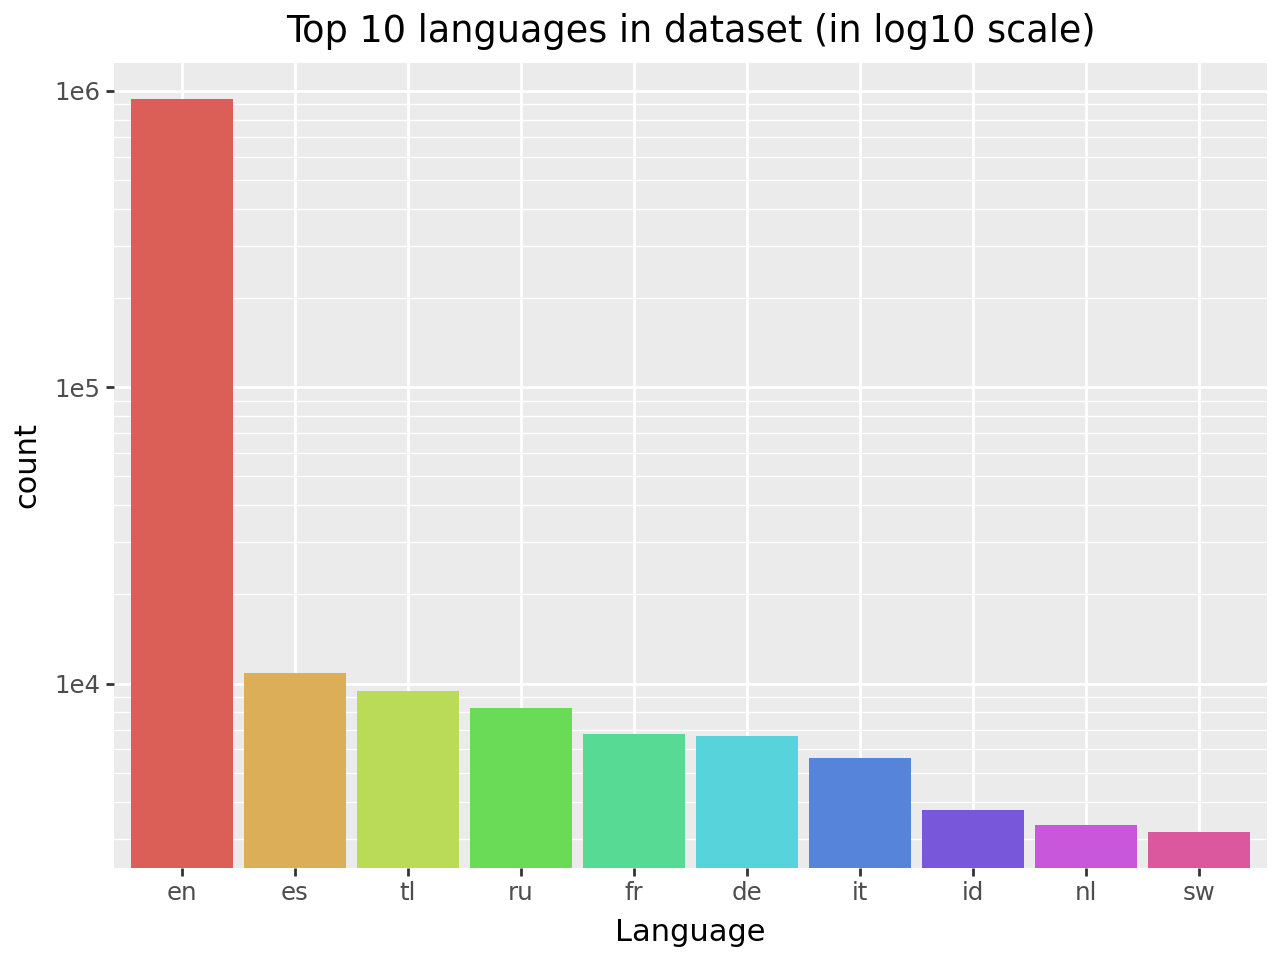

In [17]:
top10_lang = data["Language"].value_counts(sort=True)[:10]
top10_lang = top10_lang.with_columns(Language = pl.col("Language").cast(pl.Categorical('physical')))

(pltn.ggplot(top10_lang) +
 pltn.aes(x="Language",
          y="count",
          fill="Language") +
 pltn.geom_bar(stat="identity") +
 pltn.scale_y_log10()+
 pltn.labs(title="Top 10 languages in dataset (in log10 scale)") +
 pltn.theme(legend_position="none"))


In [18]:
x = len(data.filter(pl.col("Language") == "en")) / len(data) *100
Markdown(f"English encompasses {x:.2f}% of the dataset")

English encompasses 90.81% of the dataset

## Categories
`CategoryID` is one of more intresting features in the dataset. 
It can tell what the videos can be about. In order for the dataset to be viable for sentiment analysis,
the data should encompass wide range of topics.

In [19]:
category_dict = {
    2: "Autos & Vehicles",
    1: "Film & Animation",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

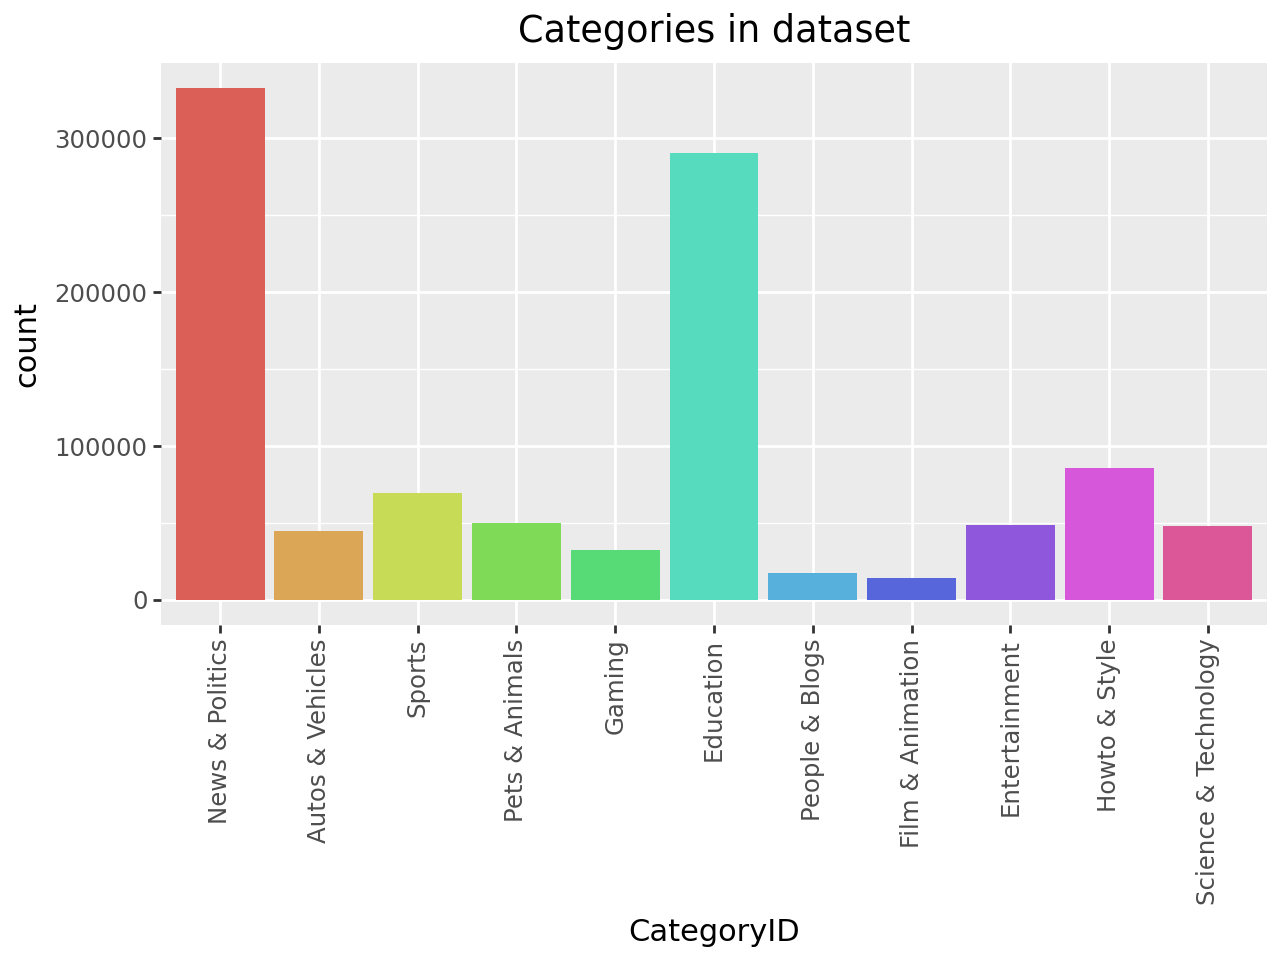

In [20]:
cat_data = (data["CategoryID"]
            .value_counts()
            .with_columns(
                CategoryID = pl.col("CategoryID")
                .replace_strict(category_dict)
                .cast(pl.Categorical(ordering="physical"))))

(pltn.ggplot(cat_data)+
 pltn.aes(y="count",x="CategoryID", fill ="CategoryID") +
 pltn.geom_bar(stat="identity") +
 pltn.theme(axis_text_x= pltn.element_text(angle=90)) +
 pltn.labs(title="Categories in dataset")+
 pltn.theme(legend_position="none"))

`Education` and `News & Politics` are the most common category in the dataset. \
When evaluating the model we should check the performance by CategoryID for video.

In [21]:

def generate_wordcloud(
        df: pl.dataframe,
        col: str,
        #title: str
        ) -> wordcloud.WordCloud:
    
    text :str = (df.select(pl.col(col)
                          .str.join(" ")) # combine comments into single Big string
                          .item())
    
    word_plot = wordcloud.WordCloud(max_words=100,
                                     background_color="white",
                                     height=400,
                                     width=600
                                    
                                     ).generate(text)
    
    return word_plot
    #fig, ax = plt.subplots(figsize=(8, 6))
    #ax.imshow(word_plot)
    #ax.axis("off")
    #fig.suptitle(title, fontsize=32)
    #return fig
    


#f = generate_wordcloud(data.filter(pl.col("CategoryID").replace_strict(category_dict) == "Education"), "CommentText","Most common words")
#plt.show()

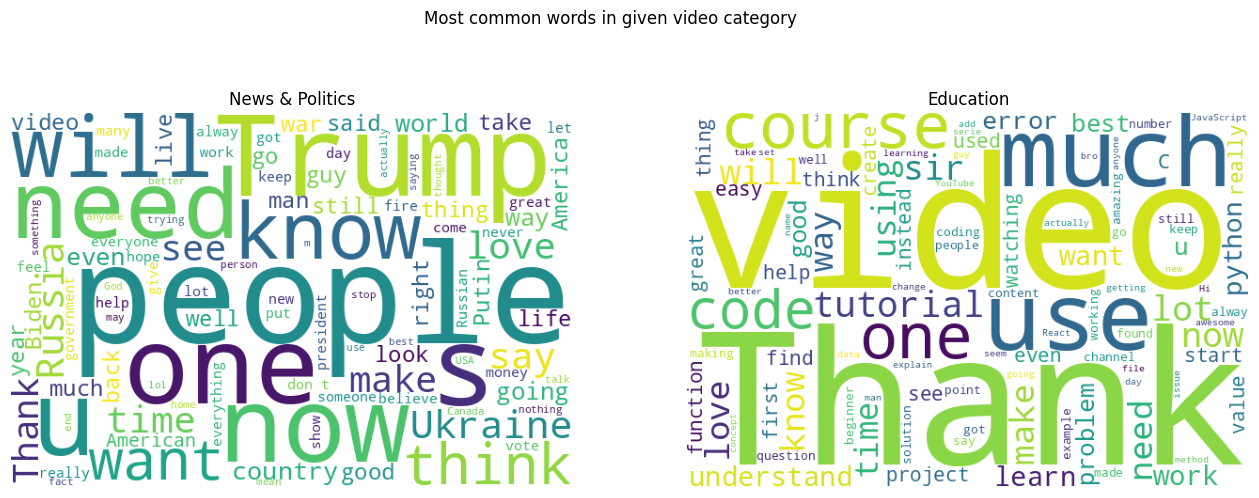

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i, col in enumerate((25, 27)):
    ax[i].imshow(generate_wordcloud(data.filter(pl.col("CategoryID") == col),
                                    "CommentText"))
    ax[i].axis("off")
    ax[i].title.set_text(category_dict[col])

fig.suptitle("Most common words in given video category")
plt.show()


Let's now check of sentiments are distributed across diffrent categories

In [23]:
def get_entropy(row : Tuple[Any, float, float, float]
                ) -> float:
    entropy = 0
    for i in (1,2,3):
        entropy += -row[i] * np.log(row[i]) / np.log(3)

    return entropy

table = (data 
 .with_columns(pl.col("CategoryID")
               .replace_strict(category_dict))
 .group_by(pl.col("CategoryID"))
 .agg(pl.col("Sentiment").value_counts(normalize=True))
 .explode("Sentiment")
 .unnest("Sentiment")
 .pivot(on="Sentiment",
        index="CategoryID",
        values="proportion")
 .select(["CategoryID", "Negative", "Neutral", "Positive"])) # change column order

entropy = table.map_rows(get_entropy, return_dtype=pl.Float64).to_series()
table = table.with_columns(Entropy = entropy).sort(by="Entropy", descending=False)
pl.Config.set_tbl_rows(len(table)) # change confg so that polars will print entire table

print(table)

shape: (11, 5)
┌──────────────────────┬──────────┬──────────┬──────────┬──────────┐
│ CategoryID           ┆ Negative ┆ Neutral  ┆ Positive ┆ Entropy  │
│ ---                  ┆ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str                  ┆ f64      ┆ f64      ┆ f64      ┆ f64      │
╞══════════════════════╪══════════╪══════════╪══════════╪══════════╡
│ People & Blogs       ┆ 0.206308 ┆ 0.228611 ┆ 0.565081 ┆ 0.89708  │
│ Education            ┆ 0.188804 ┆ 0.387404 ┆ 0.423792 ┆ 0.952061 │
│ Science & Technology ┆ 0.424917 ┆ 0.360411 ┆ 0.214672 ┆ 0.966471 │
│ Autos & Vehicles     ┆ 0.439228 ┆ 0.299962 ┆ 0.26081  ┆ 0.976752 │
│ Sports               ┆ 0.41388  ┆ 0.286215 ┆ 0.299905 ┆ 0.987015 │
│ News & Politics      ┆ 0.406735 ┆ 0.304219 ┆ 0.289045 ┆ 0.989133 │
│ Film & Animation     ┆ 0.340128 ┆ 0.375524 ┆ 0.284348 ┆ 0.994154 │
│ Howto & Style        ┆ 0.383827 ┆ 0.310741 ┆ 0.305431 ┆ 0.994875 │
│ Entertainment        ┆ 0.370285 ┆ 0.338574 ┆ 0.291142 ┆ 0.995624 │
│ Pets & Animals   

Generally most categories seem to be rather balanced. \
`People & Blogs` Is the most unbalanced category in the dataset, with overwhelming amount of positive comments in the videos. \
`Autos & Vehicles` is the Category with the most Negative comments rate, which is kind of suprising, considering `News & Politics` is also a category. 

## Likes and Replies Distribution
Let's look how number of Likes and replies interact with each other

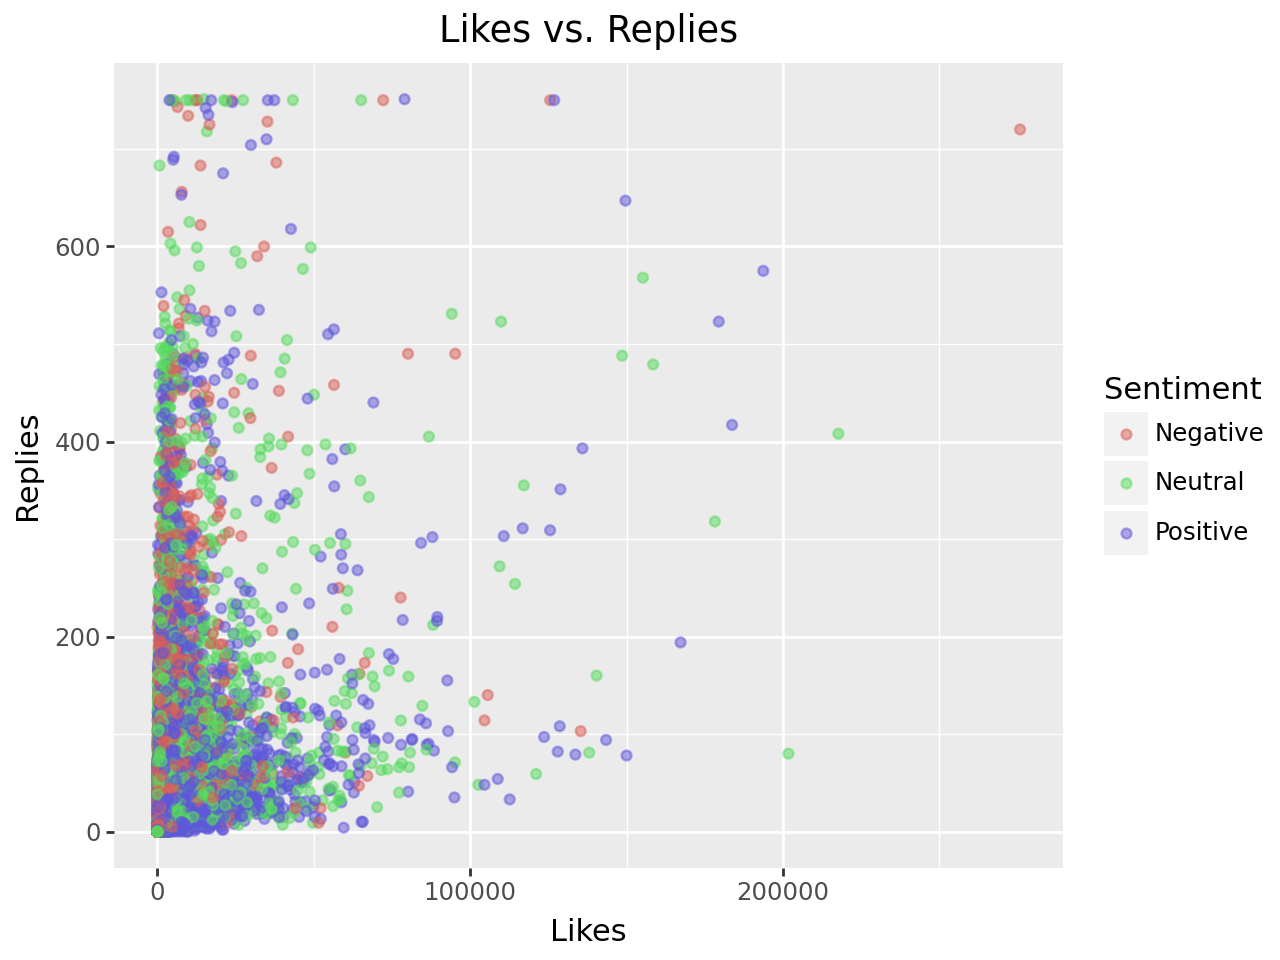

In [24]:
plot_data = data.select(["Likes", "Replies", "Sentiment"]).with_columns( (pl.col("Likes") + 1).alias("Likes"))

(pltn.ggplot(data) +
 pltn.aes(x="Likes", 
          y="Replies",
          color="Sentiment") +
 pltn.geom_point(alpha=0.5) +
 #pltn.scale_x_log10() +
 #pltn.scale_y_continuous(pltn.)
 pltn.labs(title="Likes vs. Replies"))


In [25]:
get_quantiles(data, "Likes").with_columns(Replies=get_quantiles(data, "Replies")["value"]).rename({"value":"Likes"})

quantile,Likes,Replies
f64,f64,f64
0.0,0.0,0.0
0.25,0.0,0.0
0.5,0.0,0.0
0.75,2.0,0.0
1.0,275849.0,751.0


In [26]:
display(Markdown(f"Only {len(data.filter(pl.col('Likes') > 0))/len(data)*100:.2f}% of Comments has at least a one like,"
f" {len(data.filter(pl.col('Replies')>0))/len(data)*100:.2f}% at least one reply"))

Only 36.23% of Comments has at least a one like, 17.88% at least one reply

Big majority of comments don't have a single comment or reply \
Now let's look at comment/reply rates by `Sentiment`

In [27]:
lr_data = (data
 .group_by("Sentiment")
 .agg(pl.col("Likes").sum() / data["Likes"].sum(),
      pl.col("Replies").sum() / data["Replies"].sum()))

lr_data

Sentiment,Likes,Replies
str,f64,f64
"""Negative""",0.180618,0.329064
"""Positive""",0.486032,0.385318
"""Neutral""",0.33335,0.285619


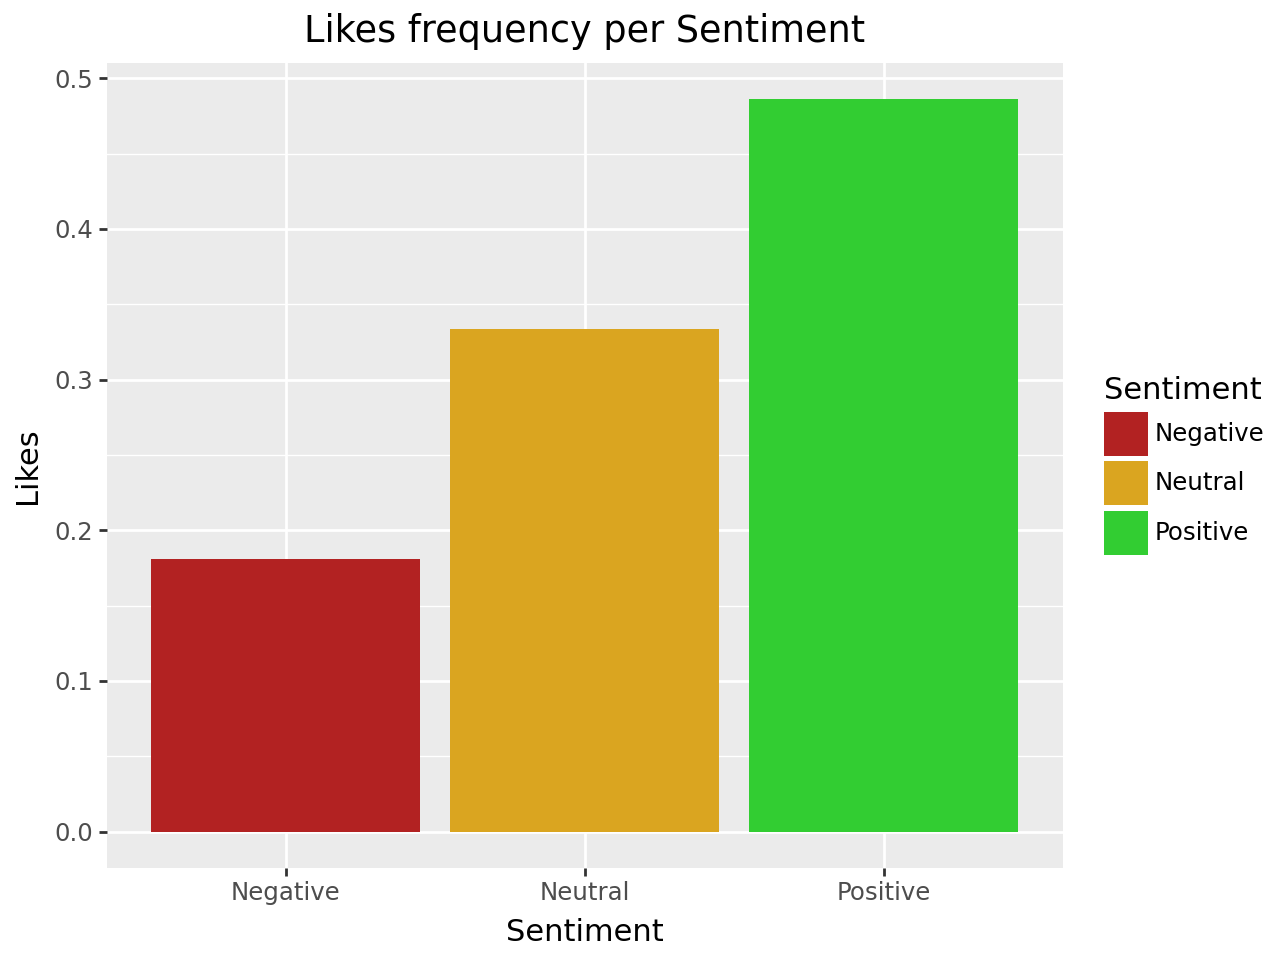

In [28]:
(pltn.ggplot(lr_data ) +
 pltn.aes(y="Likes", x="Sentiment", fill="Sentiment") +
 pltn.geom_bar(stat="identity") +
 pltn.labs(title="Likes frequency per Sentiment") +
 COLOR_PALETTE)

It seems that positive comments have the biggest like rate, let's test this hypothesis using chi-square test

In [ ]:
exp_freq = (data["Likes"].sum()/3, data["Likes"].sum()/3, data["Likes"].sum()/3)
obs_freq = (lr_data["Likes"] * data["Likes"].sum())

H_0 = "Observed diffrences to expected distribution are due to chance"
H_1 = "Observed diffrences to expected distribution are NOT due to chance" 
ALPHA = 0.05

results= chisquare(obs_freq, exp_freq)

results

if (results.pvalue < ALPHA):
    print(H_n)
else:
    print(H_0)

Observed diffrences to expected distribution are NOT due to chance


So we have established that distribution of Like rates per Sentiment is not equal. \
Could this be a factor in model development?

## Sentiment and Comment Length

Intresting hypothesis to be is that Negative/Neutral/Positive comments will have diffrent lengths. \
Let's Invesigate! 

In [30]:
data = data.with_columns(Length = pl.col("CommentText").str.len_chars())

In [31]:
get_quantiles(data, "Length")

quantile,value
f64,f64
0.0,1.0
0.25,34.0
0.5,65.0
0.75,121.0
1.0,9997.0


So the median of Comment Length is 65 characters. The Longest Comment has **9997** characters in it which seems like a lot.

In [32]:
data.filter(pl.col("Length") == pl.col("Length").max())

CommentID,VideoID,VideoTitle,AuthorName,AuthorChannelID,CommentText,Sentiment,Likes,Replies,PublishedAt,CountryCode,CategoryID,Language,Length
str,str,str,str,str,str,str,i64,i64,str,str,i64,str,u32
"""Ugx1beWD3QSMuVuuHT54AaABAg""","""tcmPLtOQw20""","""Update from Ukraine | Useless …","""@Save.me.oi.Zelensky""","""UChhNcsBQzJmwmxvJUjqQ7Tw""","""25 of 27/2024y. The Ukrainian-…","""Negative""",0,0,"""2025-01-14 09:54:22""","""IE""",25,"""en""",9997
"""Ugxr8iwuml5bnTtrpbN4AaABAg""","""tcmPLtOQw20""","""Update from Ukraine | Useless …","""@Save.me.oi.Zelensky""","""UChhNcsBQzJmwmxvJUjqQ7Tw""","""25 of 27/2024y. The Ukrainian-…","""Negative""",0,0,"""2025-01-14 10:30:09""","""IE""",25,"""en""",9997
"""UgwCXlSlmN7YoTDMxUB4AaABAg""","""tcmPLtOQw20""","""Update from Ukraine | Useless …","""@Save.me.oi.Zelensky""","""UChhNcsBQzJmwmxvJUjqQ7Tw""","""25 of 27/2024y. The Ukrainian-…","""Negative""",1,0,"""2025-01-14 10:27:26""","""IE""",25,"""en""",9997
"""UgzkdN-orfz13QuexWh4AaABAg""","""tcmPLtOQw20""","""Update from Ukraine | Useless …","""@Save.me.oi.Zelensky""","""UChhNcsBQzJmwmxvJUjqQ7Tw""","""25 of 27/2024y. The Ukrainian…","""Negative""",0,0,"""2025-01-14 10:25:15""","""IE""",25,"""en""",9997


It seems that these are copies of each other.

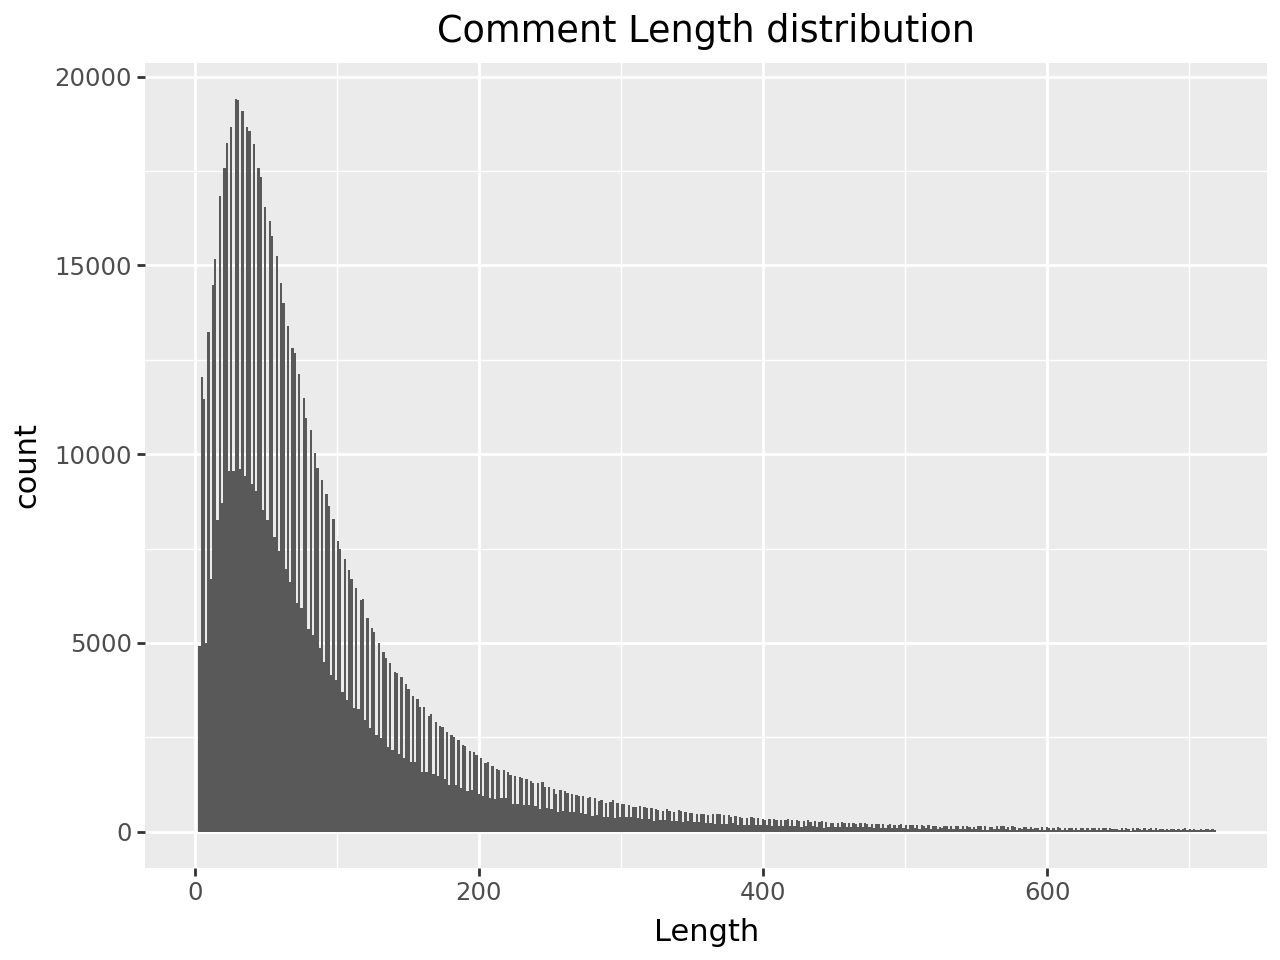

In [58]:
(pltn.ggplot(data) +
 pltn.aes("Length") +
 #pltn.geom_boxplot()+
 pltn.geom_histogram(bins=450) +
 #pltn.geom_boxplot() +
 pltn.xlim(1, data["Length"].quantile(0.99)) +
 pltn.labs(title="Comment Length distribution"))

In [71]:
sent_order={"Positive": 0, "Neutral":1 ,"Negative":2}
(data
 #.filter(pl.col("Length") < pl.col("Length").quantile(0.99)) # deleting outliers
 .group_by(pl.col("Sentiment"))
 .agg(pl.col("Length").median().alias("Median Length"),
      pl.col("Length").mean().alias("Mean Length"),
      pl.col("Length").std().alias("Length Std"))
 .sort(by=pl.col("Sentiment").replace_strict(sent_order))
)

Sentiment,Median Length,Mean Length,Length Std
str,f64,f64,f64
"""Positive""",64.0,103.171125,148.227812
"""Neutral""",53.0,92.084408,186.511081
"""Negative""",79.0,125.932318,194.662315


Intresting. Negative Comments seem to be the longest ones in the dataset, intresting finding. Is it due to negative emotions in people? \
Let's see if the data confirms aout suspisions

In [88]:
H_0 = "Each sample comes from the same Length distribution"
H_1 = "Samples come from different Length distributions"
ALPHA = 0.05
result = kruskal(data.filter(pl.col("Sentiment") == "Positive")["Length"].to_numpy(),
                 data.filter(pl.col("Sentiment") == "Negative")["Length"].to_numpy(),
                 data.filter(pl.col("Sentiment") == "Neutral")["Length"].to_numpy(),
                 nan_policy="raise")

if result.pvalue >= ALPHA:
    print(H_0)
else:
    print(H_1)

print(f"P value: {result.pvalue}")

Samples come from different Length distributions
P value: 0.0


So we established that Lenth distributions in each sentiment sample are diffrent.

# Conclusions

- Sentiments in dataset are balanced
- Comments came for ~4500 unique videos
- Majority of comments are made by unique authors
- over 90% of the datasets consists of comments in english language
- Comments in dataset represent many categories of youtube videos, yet `News & politics` and `Education` are the most
represented categories
- Sentiments across categories seems to be balanced, with exception being `Peoples & Blogs` and `Education` where majority of 
comments are positive
- Like rates are not evenly distributed across Categories.
- `CommentLength` median differs across `Sentiment`
